In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sys
import os
sys.path.insert(1, '/idia/projects/hi_im/meerpower/meerpower')
import Init
import plot
matplotlib.rcParams['figure.figsize'] = (18, 9)

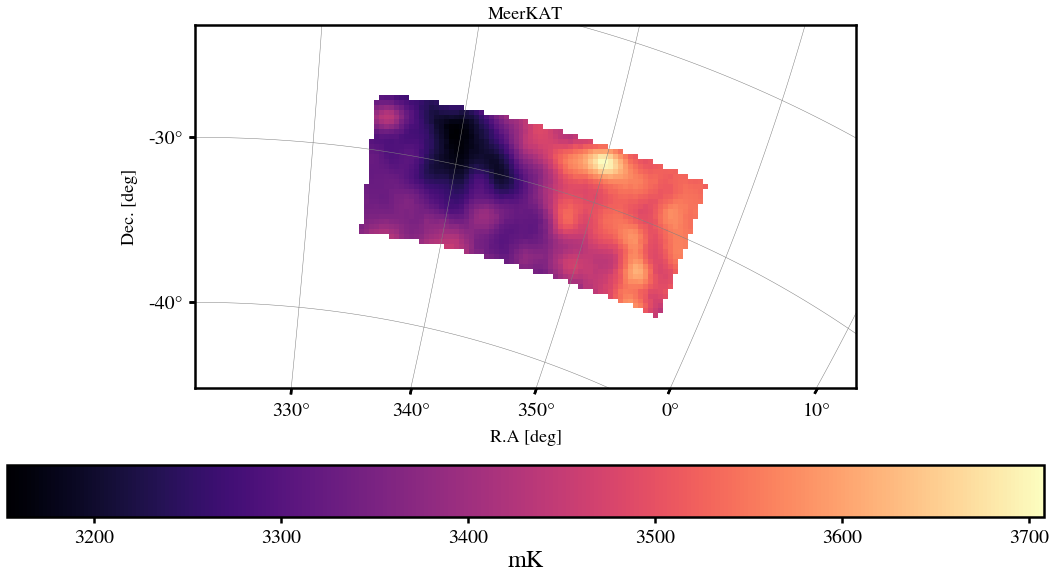

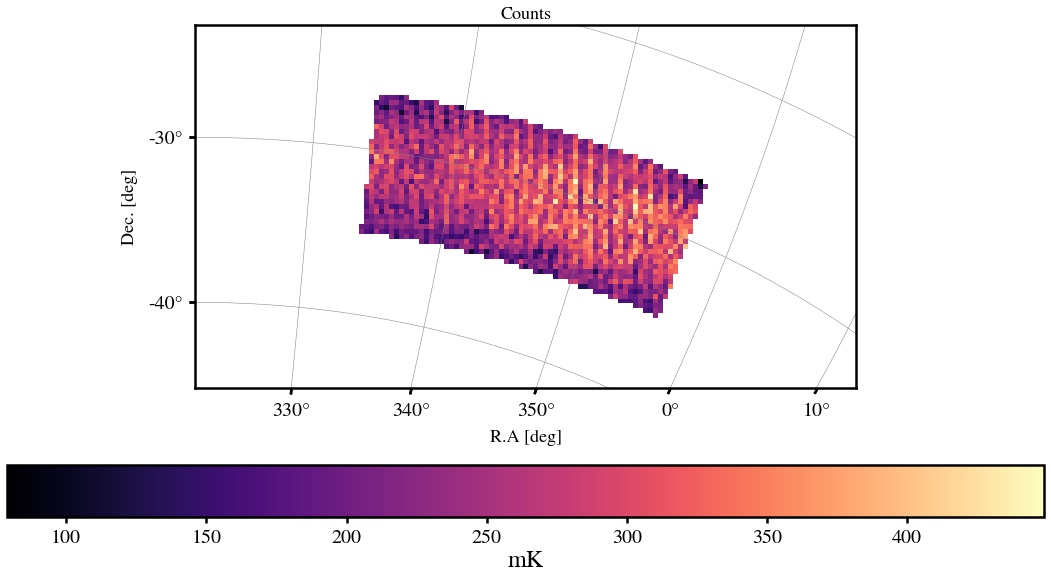

In [2]:
# Read-in level6 MeerKAT data:
#filestem = '/idia/projects/hi_im/raw_vis/MeerKLASS2021/level6/0.3/sigma_3/data/'
#map_file = filestem + 'Nscan966_Tsky_cube_p0.3d_sigma3.0_iter2.fits'
filestem = '/idia/users/jywang/MeerKLASS/calibration2021/level6/0.3/sigma4_count40/re_cali1_round5/'
map_file = filestem + 'Nscan961_Tsky_cube_p0.3d_sigma4.0_iter2.fits'
MKmap,w_HI,W_HI,counts_HI,dims,ra,dec,nu,wproj = Init.ReadIn(map_file)

### Initialise some fiducial cosmology and survey parameters:
import cosmo
nu_21cm = 1420.405751 #MHz
zeff = (nu_21cm/np.median(nu)) - 1 # Effective redshift (redshift of median frequency)
cosmo.SetCosmology(builtincosmo='Planck18',z=zeff,UseCLASS=True)
Pmod = cosmo.GetModelPk(zeff,kmax=25,UseCLASS=True) # high-kmax needed for large k-modes in NGP alisasing correction
f = cosmo.f(zeff)
sig_v = 0
b_HI = 1.5
b_g = 1.6 # tuned by eye in GAMA auto-corr
OmegaHIbHI = 0.85e-3 # MKxWiggleZ constraint
OmegaHI = OmegaHIbHI/b_HI
import HItools
import telescope
Tbar = HItools.Tbar(zeff,OmegaHI)
D_dish = 13.5 # Dish-diameter [metres]
theta_FWHM,R_beam = telescope.getbeampars(D_dish,np.median(nu))

### Remove incomplete LoS pixels from maps:
MKmap,w_HI,W_HI,counts_HI = Init.FilterIncompleteLoS(MKmap,w_HI,W_HI,counts_HI)

### Trim map edges (can fine-tune boarders if needed):
raminMK,ramaxMK = 334,357
decminMK,decmaxMK = -35,-26.5
MKmap,w_HI,W_HI,counts_HI = Init.MapTrim(ra,dec,MKmap,w_HI,W_HI,counts_HI,ramin=raminMK,ramax=ramaxMK,decmin=decminMK,decmax=decmaxMK)

### Use counts map as weights:
w_HI = counts_HI # Not factorised along LoS so will add rank if used in foreground cleaning in current form

plot.Map(MKmap,W=W_HI,map_ra=ra,map_dec=dec,wproj=wproj,title='MeerKAT')
plot.Map(counts_HI,W=W_HI,map_ra=ra,map_dec=dec,wproj=wproj,title='Counts')
plt.show()

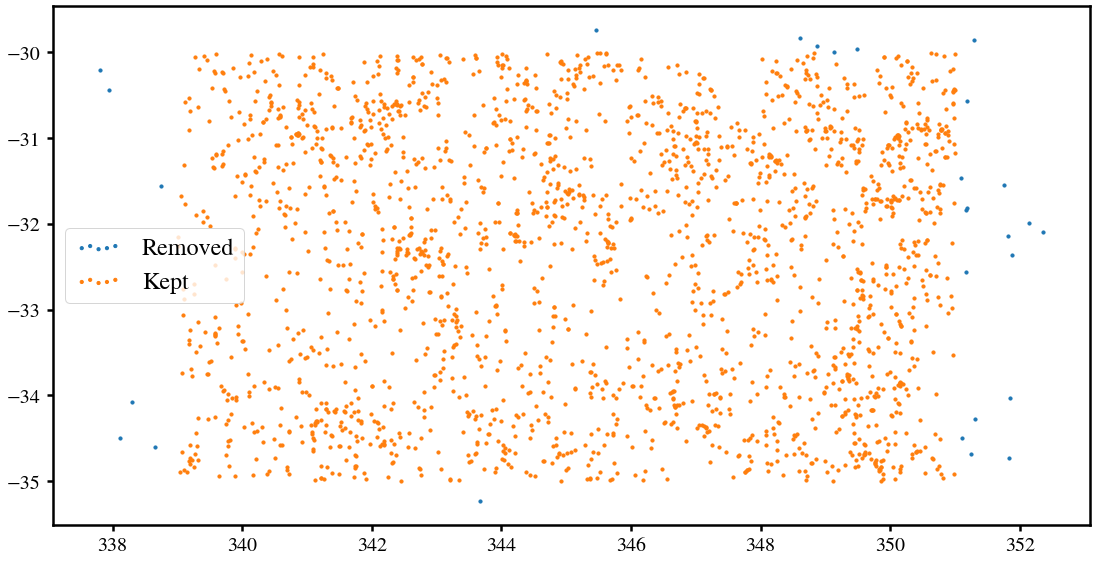

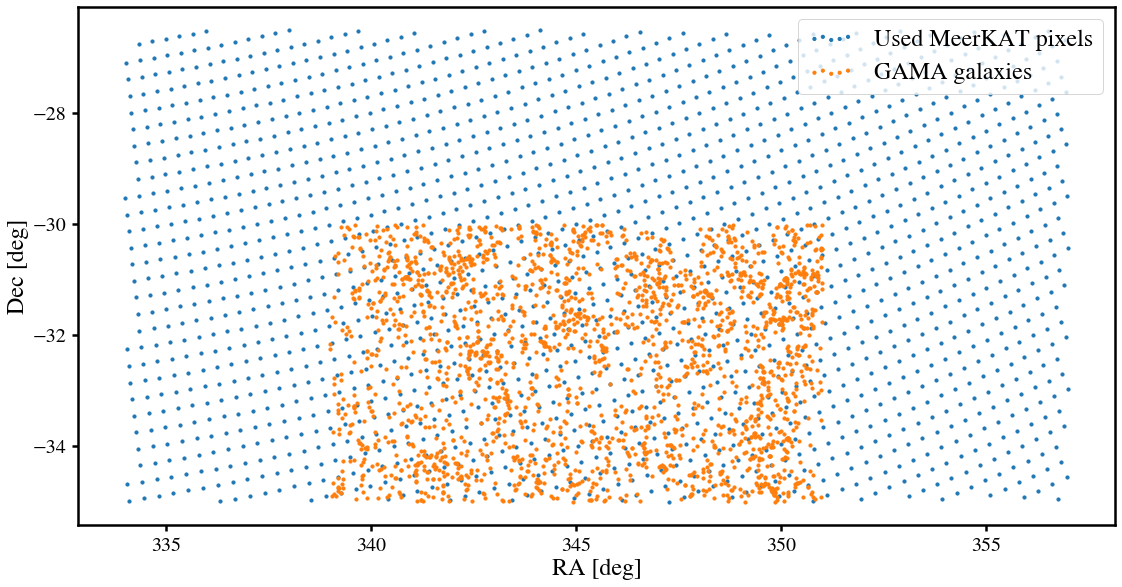

In [3]:
# Read-in GAMA G-23 field galaxies:
from astropy.io import fits
Fits = '/idia/projects/hi_im/GAMA_DR4/G23TilingCatv11.fits'
hdu = fits.open(Fits)
hdr = hdu[1].header
#print(hdr)
ra_g = hdu[1].data['RA'] # Right ascension (J2000) [deg]
dec_g = hdu[1].data['DEC'] # Declination (J2000) [deg]
z_g = hdu[1].data['Z'] # Spectroscopic redshift, -1 for none attempted

### Cut redshift to MeerKAT IM range:
zmin,zmax = HItools.Freq2Red(np.max(nu)),HItools.Freq2Red(np.min(nu))
z_Lband = (z_g>zmin) & (z_g<zmax)
ra_g = ra_g[z_Lband]
dec_g = dec_g[z_Lband]
z_g = z_g[z_Lband]

### Remove galaxies outside bulk GAMA footprint so they don't bias the simple binary selection function
raminGAMA,ramaxGAMA = 339,351
decminGAMA,decmaxGAMA = -35,-30
GAMAcutmask = (ra_g>raminGAMA) & (ra_g<ramaxGAMA) & (dec_g>decminGAMA) & (dec_g<decmaxGAMA)
plt.scatter(ra_g[~GAMAcutmask],dec_g[~GAMAcutmask],s=10,label='Removed')
ra_g,dec_g,z_g = ra_g[GAMAcutmask],dec_g[GAMAcutmask],z_g[GAMAcutmask]
plt.scatter(ra_g,dec_g,s=10,label='Kept')
plt.legend()
plt.show()

### For null testing:
#np.random.shuffle(z_g)

#### WHY ISN'T THIS PLOT WORKING - ASK JINGYING! ##########
'''
#plot.Map(MKmap,W=W_HI,map_ra=map_ra,map_dec=map_dec,wproj=wproj,title='MeerKAT')
#plt.show()
plt.subplot(projection=wproj)
ax = plt.gca()
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('d')
lon.set_ticks_position('b')
lat.set_ticks_position('l')
plt.grid(True, color='grey', ls='solid',lw=0.5)
#plt.scatter(ra_g,dec_g)
plt.imshow(np.mean(MKmap,2).T)
plt.plot(ra_g,dec_g)
plt.show()
'''
####################################################################################################

plt.scatter(ra[W_HI[:,:,0]==1],dec[W_HI[:,:,0]==1],s=10,label='Used MeerKAT pixels')
plt.scatter(ra_g,dec_g,s=10,label='GAMA galaxies')
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')
plt.legend()
plt.show()

### Cartesian regridding:

In [4]:
import grid # use this for going from (ra,dec,freq)->(x,y,z) Cartesian-comoving grid
window = 'ngp'
compensate = True
interlace = True
Np = 5 # number of Monte-Carlo sampling particles per map voxel used in regridding
nxmap,nymap,nzmap = np.shape(MKmap)
cell2vox_factor = 1.5 # increase for lower resolution FFT Cartesian grid
ndim_rg = int(nxmap/cell2vox_factor),int(nymap/cell2vox_factor),int(nzmap/cell2vox_factor)
dims_rg,dims0_rg = grid.comoving_dims(ra,dec,nu,wproj,ndim_rg,W=W_HI) # dimensions of Cartesian grid for FFT
lx,ly,lz,nx_rg,ny_rg,nz_rg = dims_rg

# Grid GAMA galaxies straight to Cartesian field:
xp,yp,zp = grid.SkyCoordtoCartesian(ra_g,dec_g,z_g,ramean_arr=ra,decmean_arr=dec,doTile=False)
n_g_rg,W_fft,counts = grid.mesh(xp,yp,zp,dims=dims0_rg,window=window,compensate=compensate,interlace=interlace,verbose=False)

# Grid uncut pixels to obtain binary masks in Cartesian space:
ra_p,dec_p,nu_p = grid.SkyPixelParticles(ra,dec,nu,wproj,Np=Np)
MKcutmask = (ra_p>raminMK) & (ra_p<ramaxMK) & (dec_p>decminMK) & (dec_p<decmaxMK)
xp,yp,zp = grid.SkyCoordtoCartesian(ra_p[MKcutmask],dec_p[MKcutmask],HItools.Freq2Red(nu_p[MKcutmask]),ramean_arr=ra,decmean_arr=dec,doTile=False)
null,W01_HI_rg,counts = grid.mesh(xp,yp,zp,dims=dims0_rg,window='ngp',compensate=False,interlace=False,verbose=False)
GAMAcutmask = (ra_p>raminGAMA) & (ra_p<ramaxGAMA) & (dec_p>decminGAMA) & (dec_p<decmaxGAMA)
xp,yp,zp = grid.SkyCoordtoCartesian(ra_p[GAMAcutmask],dec_p[GAMAcutmask],HItools.Freq2Red(nu_p[GAMAcutmask]),ramean_arr=ra,decmean_arr=dec,doTile=False)
null,W01_g_rg,counts = grid.mesh(xp,yp,zp,dims=dims0_rg,window='ngp',compensate=False,interlace=False,verbose=False)

# Regrid IM weights to Cartesian field (regrid HI IM map later after foreground cleaning):
ra_p,dec_p,nu_p,pixvals = grid.SkyPixelParticles(ra,dec,nu,wproj,map=w_HI,W=W_HI,Np=Np)
xp,yp,zp = grid.SkyCoordtoCartesian(ra_p,dec_p,HItools.Freq2Red(nu_p),ramean_arr=ra,decmean_arr=dec,doTile=False)
w_HI_rg,W_fft,counts = grid.mesh(xp,yp,zp,pixvals,dims0_rg,window,compensate,interlace,verbose=False)

# Create tapering to apply to Cartesian fields
# - needs to taper a conical footprint so currently using a technique that Gaussian smooths inwards from the empty edges:
doTaper = True # Implement apodisation window functions to apply to maps and weights to taper edges
if doTaper==True:
    # Gaussian smoothing from empty edges:
    taper_HI = np.copy(W01_HI_rg)
    taper_g = np.copy(W01_g_rg)
    from scipy.ndimage import gaussian_filter
    for i in range(8):
        taper_HI = gaussian_filter(taper_HI, sigma=1, mode='reflect')
        taper_HI[W01_HI_rg==0] = 0
        taper_g = gaussian_filter(taper_g, sigma=1, mode='reflect')
        taper_g[W01_g_rg==0] = 0
'''
### Plots to check tapering of conical footprint is working:
#W01_g_rg = np.copy(taper_HI)
W01_HI_rg = np.copy(taper_g)
plt.imshow(W01_HI_rg[:,:,int(nz_rg/2)])
plt.figure()
plt.imshow(W01_HI_rg[:,int(ny_rg/2),:])
plt.figure()
plt.imshow(W01_HI_rg[int(nx_rg/2),:,:])
plt.figure()
plt.imshow(W01_g_rg[:,:,int(nz_rg/2)])
plt.figure()
plt.imshow(W01_g_rg[:,int(ny_rg/2),:])
plt.figure()
plt.imshow(W01_g_rg[int(nx_rg/2),:,:])
plt.show()
'''

if doTaper==False: taper_HI,taper_g = 1,1
# Multiply tapering window by all galaxy fields that undergo Fourier transforms
n_g_rg = taper_g*n_g_rg
W01_g_rg = taper_g*W01_g_rg
w_g_rg = np.ones(np.shape(n_g_rg))
w_g_rg = taper_g*w_g_rg
# Multiply tapering window by HI weights and window (final HI IM field is tapered later after foreground cleaning)
w_HI_rg,W01_HI_rg = taper_HI*w_HI_rg,taper_HI*W01_HI_rg

### Power spectrum measurement and modelling:

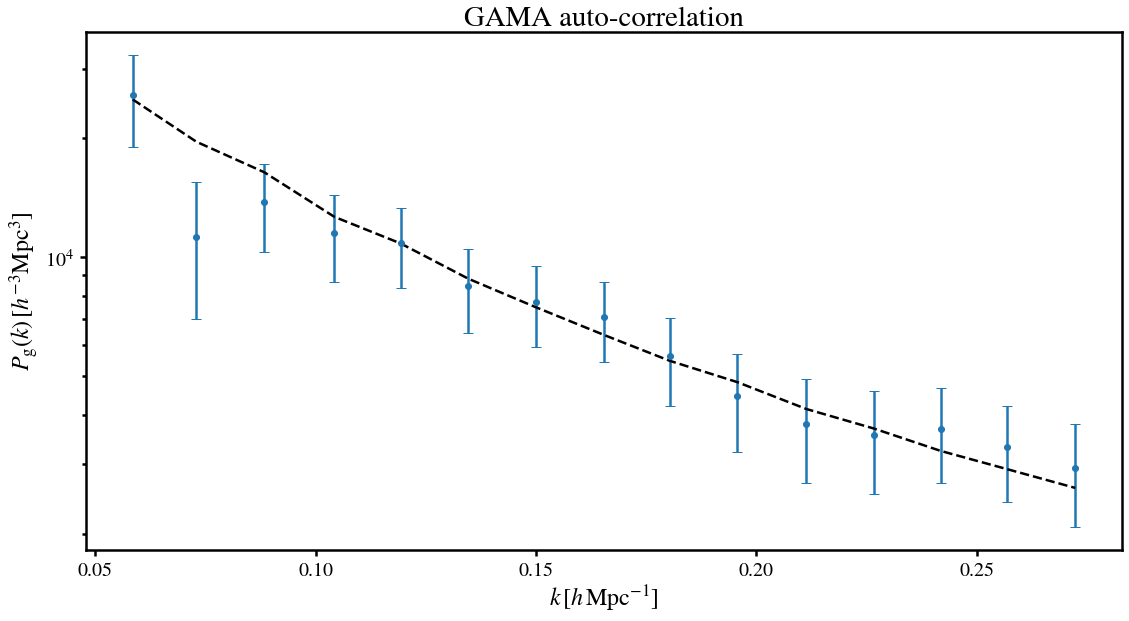

0
1
2


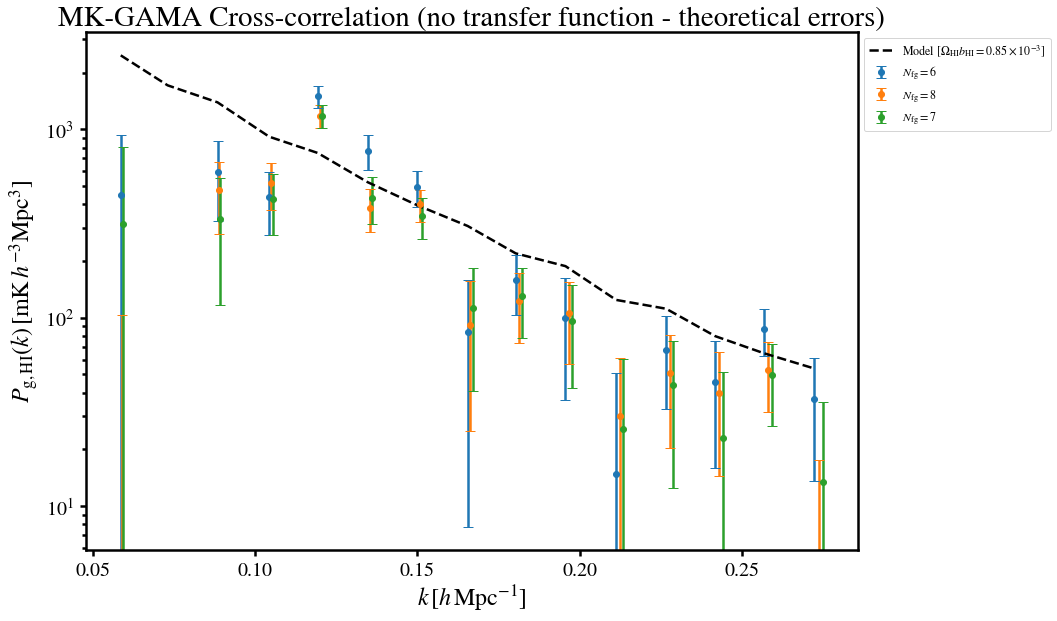

In [5]:
import foreground
import power # All power spectrum calculations performed in this script
import model
nkbin = 15
kmin,kmax = 0.05,0.28
kbins = np.linspace(kmin,kmax,nkbin+1) # k-bin edges [using linear binning]
kcuts = None
#kcuts = [None,0.01,0.2,None] #[kperpmin,kparamin,kperpmax,kparamax] (exclude areas of k-space from spherical average)
# Chose factorisation of P(k) in plotting:
norm = np.ones(nkbin)
#norm = k**2

### GAMA Auto-power (use to constrain bias):
Pk_g,k,nmodes = power.Pk(n_g_rg,n_g_rg,dims_rg,kbins,corrtype='Galauto',w1=w_g_rg,w2=w_g_rg,W1=W01_g_rg,W2=W01_g_rg)
nbar = np.sum(n_g_rg)/(lx*ly*lz) # Calculate number density inside survey footprint
P_SN = np.ones(len(k))*1/nbar # approximate shot-noise for errors (already subtracted in Pk estimator)
pkmod,k = model.PkMod(Pmod,dims_rg,kbins,b_g,b_g,f,sig_v,Tbar1=1,Tbar2=1,r=1,R_beam1=0,R_beam2=0,w1=w_g_rg,w2=w_g_rg,W1=W01_g_rg,W2=W01_g_rg,interpkbins=True,MatterRSDs=False,gridinterp=True)[0:2]
sig_g = 1/np.sqrt(nmodes)*(Pk_g+P_SN)
plt.errorbar(k,Pk_g,sig_g,ls='none',marker='o')
plt.plot(k,pkmod,color='black',ls='--',label=r'Model [$\Omega_{\rm HI}b_{\rm HI} = %s \times 10^{-3}]$'%np.round(OmegaHI*b_HI*1e3,2))
plt.yscale('log')
plt.title('GAMA auto-correlation')
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$P_{\rm g}(k)\,[h^{-3}{\rm Mpc}^{3}]$')
plt.axhline(0,lw=0.8,color='black')
plt.show()

### Foreground clean and measure cross power spectra:
#N_fgs = [7]
N_fgs = [6,8,7]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']
for i in range(len(N_fgs)):
    print(i)
    MKmap_clean = foreground.PCAclean(MKmap,N_fg=N_fgs[i],W=W_HI,w=None)
    '''
    shuffleindex = np.arange(0,nz,1)
    np.random.shuffle(shuffleindex)
    MKmap_clean = MKmap_clean[:,:,shuffleindex]
    '''
    # Regrid cleaned map to Cartesian field:
    ra_p,dec_p,nu_p,pixvals = grid.SkyPixelParticles(ra,dec,nu,wproj,map=MKmap_clean,W=W_HI,Np=Np)
    xp,yp,zp = grid.SkyCoordtoCartesian(ra_p,dec_p,HItools.Freq2Red(nu_p),ramean_arr=ra,decmean_arr=dec,doTile=False)
    MKmap_clean_rg,W_fft,counts = grid.mesh(xp,yp,zp,pixvals,dims0_rg,window,compensate,interlace,verbose=False)

    # Multiply tapering window by all cleaned map:
    MKmap_clean_rg = taper_HI*MKmap_clean_rg

    # Measure and plot power spectrum:
    Pk_HI,k,nmodes = power.Pk(MKmap_clean_rg,MKmap_clean_rg,dims_rg,kbins,corrtype='HIauto',w1=w_HI_rg,w2=w_HI_rg,W1=W01_HI_rg,W2=W01_HI_rg,kcuts=kcuts)
    Pk_X,k,nmodes = power.Pk(MKmap_clean_rg,n_g_rg,dims_rg,kbins,corrtype='Cross',w1=w_HI_rg,w2=W01_g_rg,W1=W01_HI_rg,W2=W01_g_rg,kcuts=kcuts)
    sig_err = 1/np.sqrt(2*nmodes) * np.sqrt( Pk_X**2 + Pk_HI*( Pk_g + P_SN ) ) # Error estimate
    plt.errorbar(k+(k/200*i),norm*Pk_X,norm*sig_err,label=r'$N_{\rm fg}=%s$'%N_fgs[i],ls='none',marker='o',color=colors[i])

# Model power spectrum:
dpix = 0.3
d_c = cosmo.d_com(HItools.Freq2Red(np.min(nu)))
s_pix = d_c * np.radians(dpix)
s_para = np.mean( cosmo.d_com(HItools.Freq2Red(nu[:-1])) - cosmo.d_com(HItools.Freq2Red(nu[1:])) )
pkmod,k = model.PkMod(Pmod,dims_rg,kbins,b_HI,b_g,f,sig_v,Tbar1=Tbar,Tbar2=1,r=1,R_beam1=R_beam,R_beam2=0,w1=W01_HI_rg,w2=W01_g_rg,W1=W01_HI_rg,W2=W01_g_rg,s_pix=s_pix,s_para=s_para,interpkbins=True,MatterRSDs=False,gridinterp=True)[0:2]
plt.plot(k,norm*pkmod,color='black',ls='--',label=r'Model [$\Omega_{\rm HI}b_{\rm HI} = %s \times 10^{-3}]$'%np.round(OmegaHI*b_HI*1e3,2))

if norm[0]==1.0: plt.yscale('log')
plt.legend(fontsize=12,loc='upper left',bbox_to_anchor=[1,1])
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
if norm[0]==1.0: plt.ylabel(r'$P_{\rm g,HI}(k)\,[{\rm mK}\,h^{-3}{\rm Mpc}^{3}]$')
else: plt.ylabel(r'$k^2\,P_{\rm g,HI}(k)\,[{\rm mK}\,h^{-1}{\rm Mpc}]$')
plt.axhline(0,lw=0.8,color='black')
plt.subplots_adjust(right=0.75)
#plt.title('Null Test (shuffled GAMA redshifts) MeerKAT 2021 x GAMA (no TF)')
plt.title('MK-GAMA Cross-correlation (no transfer function - theoretical errors)')
plt.show()

### Calculate/Load Transfer function:
##### - use to analyse covariance, assign non-Gaussian errors and correct signal loss:

100


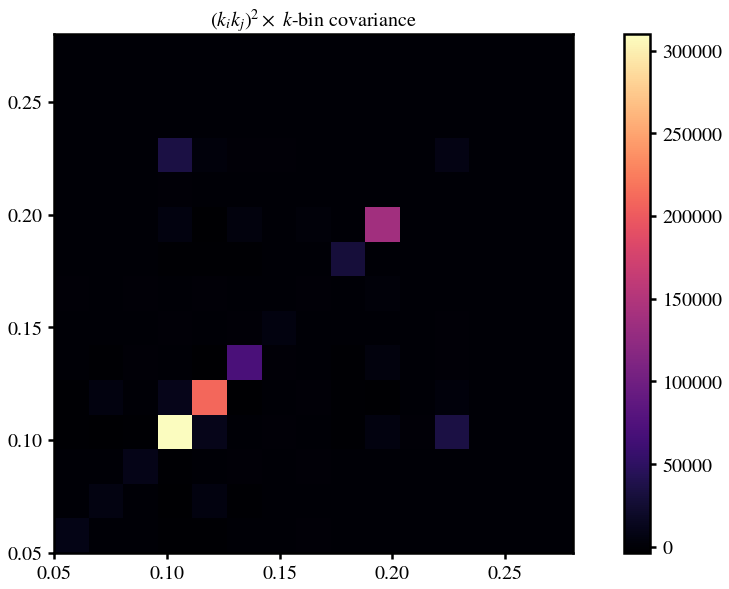

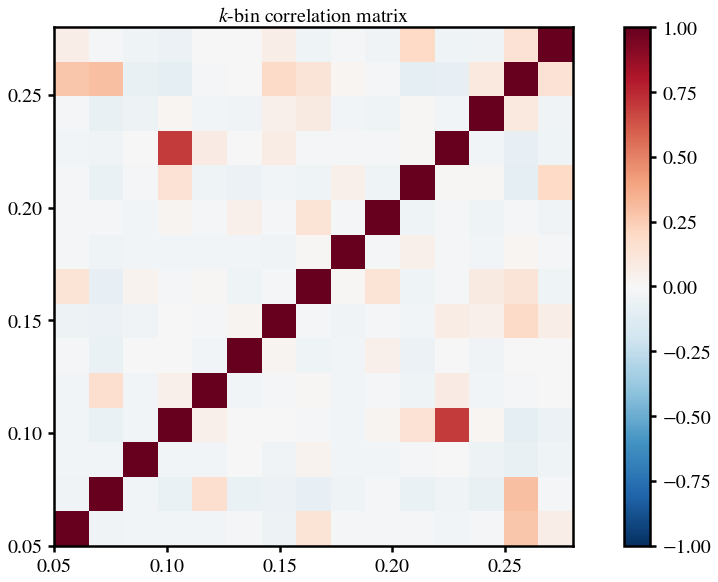

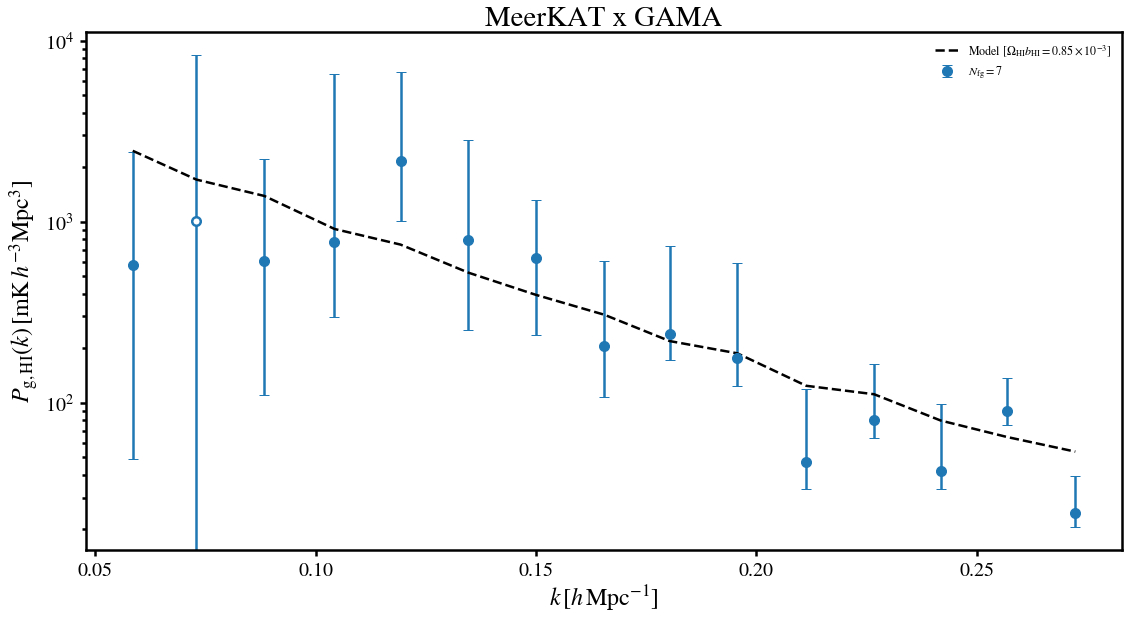

In [6]:
LoadTF = True
Nmock = 100
TFfile = '/users/scunnington/hi_im/meerpower/2021Lband/gama/TFdata/T_Nfg=%s'%N_fgs[-1]
mockfilepath_HI = '/idia/projects/hi_im/meerpower/2021Lband/mocks/dT_HI_p0.3d_wBeam'
mockfilepath_g = '/idia/projects/hi_im/meerpower/2021Lband/mocks/mockGAMAcat'
T,T_nosub,k = foreground.TransferFunction(MKmap,Nmock,N_fgs[-1],'Cross',kbins,k,TFfile,mockfilepath_HI,mockfilepath_g,W_HI,w_HI_rg,W01_HI_rg,W01_g_rg,W01_g_rg,ra,dec,nu,wproj,dims0_rg,Np,window,compensate,interlace,taper_HI,taper_g,LoadTF)
Nmock = np.shape(T)[0]
print(Nmock)

# k-bin covariance from TF:
kgrid = k * k[:,np.newaxis]
C = kgrid**2*np.cov(np.abs(Pk_X/T_nosub),rowvar=False)
plt.imshow(C,origin='lower',extent=[kbins[0],kbins[-1],kbins[0],kbins[-1]])
plt.colorbar()
plt.title(r'$(k_ik_j)^2\times$ $k$-bin covariance',fontsize=20)
plt.show()

# Noramlised k-bin correlation matrix:
R = np.corrcoef(np.abs(Pk_X/T_nosub),rowvar=False)
plt.imshow(R,origin='lower',cmap='RdBu_r',vmin=-1,vmax=1,extent=[kbins[0],kbins[-1],kbins[0],kbins[-1]])
plt.colorbar()
plt.title(r'$k$-bin correlation matrix',fontsize=20)
plt.show()

# Calculate 68th percentile regions for non-symetric/non-Gaussian errors:
lower_error = np.median(np.abs(Pk_X/T_nosub),0) - np.percentile(np.abs(Pk_X/T_nosub),50-34.1,axis=0)
upper_error = np.percentile(np.abs(Pk_X/T_nosub),50+34.1,axis=0) - np.median(np.abs(Pk_X/T_nosub),0)
asymmetric_error = np.array(list(zip(lower_error, upper_error))).T

# Plot results, correcting for signal loss and with simulation-based errors:
Pk_corr = Pk_X/np.mean(T)
plt.errorbar(k,norm*np.abs(Pk_corr),norm*asymmetric_error,ls='none',marker='o',label=r'$N_{\rm fg}=%s$'%N_fgs[-1],markersize=10)
plt.scatter(k[Pk_corr<0],norm[Pk_corr<0]*np.abs(Pk_corr[Pk_corr<0]),marker='o',facecolors='white',color='tab:blue',zorder=10,s=50)
plt.plot(k,norm*pkmod,color='black',ls='--',label=r'Model [$\Omega_{\rm HI}b_{\rm HI} = %s \times 10^{-3}]$'%np.round(OmegaHI*b_HI*1e3,2))
if norm[0]==1.0: plt.yscale('log')
plt.axhline(0,lw=0.8,color='black')
plt.legend(fontsize=12,loc='upper right',frameon=False)
plt.title('MeerKAT x GAMA')
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
if norm[0]==1.0: plt.ylabel(r'$P_{\rm g,HI}(k)\,[{\rm mK}\,h^{-3}{\rm Mpc}^{3}]$')
else: plt.ylabel(r'$k^2\,P_{\rm g,HI}(k)\,[{\rm mK}\,h^{-1}{\rm Mpc}]$')
plt.show()

### Analyse 2D Power:

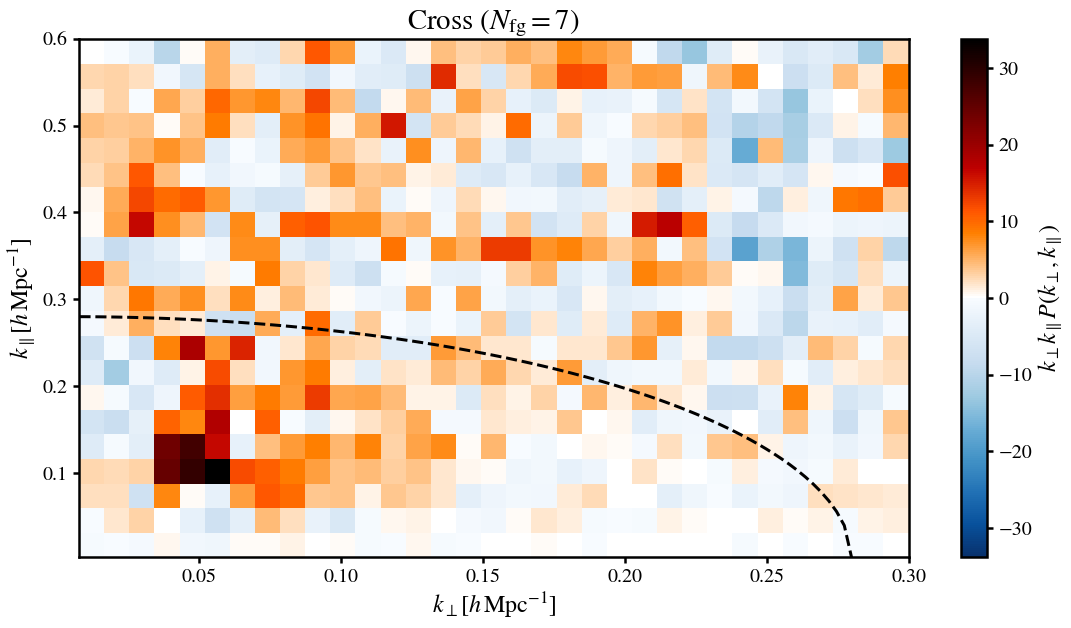

In [15]:
### Chose 2D k-bins:
kperpbins = np.linspace(0.00882353,0.3,34)
kperpbins = np.linspace(0.008,0.3,34)
kparabins = np.linspace(0.003,0.6,22)
kperpcen = (kperpbins[1:] + kperpbins[:-1])/2
kparacen = (kparabins[1:] + kparabins[:-1])/2
kperpgrid = np.tile(kperpcen,(len(kparacen),1))
kparagrid = np.tile(kparacen,(len(kperpcen),1))
kparagrid = np.swapaxes(kparagrid,0,1)
kgrid = kperpcen * kparacen[:,np.newaxis]

### Create split colorbar for 2D Pk negative values:
import matplotlib.colors as mcolors
colors1 = plt.cm.Blues_r(np.linspace(0., 1, 128))
colors2 = plt.cm.gist_heat_r(np.linspace(0, 1, 128))
colors = np.vstack((colors1, colors2))
mycmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

Pk2D,k2d,nmodes = power.Pk2D(MKmap_clean_rg,n_g_rg,dims_rg,kperpbins,kparabins,'Cross',w1=w_HI_rg,w2=W01_g_rg,W1=W01_HI_rg,W2=W01_g_rg)

vmaxX = np.max(kgrid*Pk2D)
plt.pcolormesh(kperpbins,kparabins,kgrid*Pk2D,cmap=mycmap,vmin=-vmaxX,vmax=vmaxX)
### 1D k_max contour:
kperp = np.linspace(np.min(kperpbins),kmax,100)
kpara = np.linspace(np.min(kparabins),kmax,100)
kcont = np.sqrt(kmax**2 - kpara**2)
plt.plot(kperp,kcont,color='black',ls='--',lw=3)
plt.colorbar(label=r'$k_\perp k_\parallel P(k_\perp,k_\parallel)$')
plt.xlim(left=kperpbins[0])
plt.ylim(bottom=kparabins[0])
plt.xlabel(r'$k_\perp [h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$k_\parallel [h\,{\rm Mpc}^{-1}]$')
plt.title(r'Cross ($N_{\rm fg}=%s$) '%N_fgs[-1])
plt.show()